# Introduction to hax, part I

Last updated April 2018.

This tutorial shows you how to use `hax` to get at the XENON1T processed data. We cover only the absolute basics in this part, the next two parts delve more into the details.

## The XENON1T data

XENON1T's data is structured in several levels, from low (pulses from the PMTs/digitizers) to high (events):
  * **Pulses** are stretches of raw data recorded by a digitizer. These are also called PMT waveforms.
  * Within pulses we search for **hits**, excursions above the baseline, corresponding to one or more photons hitting the PMT. 
  * Nearby hits across all channels are grouped into **peaks**. We compute their properties and classify them as S1 or S2.
  * Pairs of S1 and S2s that could be related are called **interactions**. For each interaction we can compute more properties, such as the drift time (time between S1 and S2) or the position corrected for field distortion during drift.
  * Finally, all data is segmented in few-ms stretches of time called **events**. An idealized event has one interaction, consisting of two peaks (S1 and S2) that each consist of several hits. In practice events have many peaks that are not part of interactions (such as photoionization electron signals).
  

The figure below illustrates these levels of data, and the different operations during XENON's analysis:

![title](pax_flow.png)

## XENON1T software

  * [pax](https://github.com/XENON1T/pax) is XENON's data processor. This does all the steps in the figure up to the corrections stage (and until very recently it did the correction stage too). Pax outputs a large ROOT file which stores the entire data hierarchy. In principle you can do analysis directly from this (as was done in XENON100), but today this is never done (to the best of my knowledge).
  * [hax](https://github.com/XENON1T/hax) is a library of analysis utilities. The three you'll use most often are:
    * `hax.minitrees` for loading data from pax' root file into [pandas DataFrames](http://pandas.pydata.org/pandas-docs/stable/10min.html).
    * `hax.runs` for selecting datasets of particular types;
    * `hax.cuts` for convenient event selection.
  * [lax](https://github.com/XENON1T/lax) is a collection of event selections developed for XENON1T, used in tandem with `hax.minitrees` (and `hax.cuts` if you so choose).
  * Specific analyses have dedicated packages. For example,  [blueice](https://github.com/JelleAalbers/blueice) and [xephyr](https://github.com/XENON1T/Xephyr) are used for WIMP-limit setting, while [bbf](https://github.com/XENON1T/bbf) and [laidbax](https://github.com/XENON1T/laidbax) can produce ER and NR response models.
  * The final analysis code for a science run is collected in a private repository, see [here](https://github.com/XENON1T/FirstResults) for science run 0 and [here](https://github.com/XENON1T/SR1Results) for science run 1.

## Boilerplate startup

First, we import the math library [numpy](https://en.wikipedia.org/wiki/NumPy)
and the plotting library [matplotlib](https://en.wikipedia.org/wiki/Matplotlib):

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# make plots appear without explicit plt.show():
%matplotlib inline   

Now it is time to import and intialize `hax`. This will take about half a minute (it's querying the runs db and scanning the filesystem for available datasets.

In [2]:
import hax
hax.init()

You can pass a variety of options to hax.init, which we will cover later.

# Selecting datasets

All XENON1T data is segmented into datasets, usually each one hour long. Datasets are sometimes called 'runs' -- not to be confused with 'science runs', which represent a much longer period of time containing hundreds or thousands of datasets. 

A [central database](https://xenon1t-daq.lngs.infn.it/runs/) tracks all runs and what conditions they were taken in (e.g. presence of a calibration source). Hax provides a DataFrame with all available datasets on the analysis facility in hax.runs.datasets:

In [3]:
ds = hax.runs.datasets
ds.tail()

,end,location,name,number,pax_version,reader__ini__name,reader__self_trigger,source__frequency,source__type,start,tags,trigger__events_built,trigger__status,raw_data_subfolder,raw_data_found,raw_data_used_local_path
18071,2018-04-03 14:33:46,,180403_1333,18074,,background_stable,True,NaN,none,2018-04-03 13:33:43,,22853.0,deleted,,False,
18072,2018-04-03 15:51:51,,180403_1451,18075,,background_triggerless,True,NaN,none,2018-04-03 14:51:47,,36292.0,deleted,,False,
18073,2018-04-03 16:52:02,,180403_1551,18076,,background_stable,True,NaN,none,2018-04-03 15:51:58,,22707.0,processed,,False,
18074,2018-04-03 18:14:27,,180403_1714,18077,,background_stable,True,NaN,none,2018-04-03 17:14:24,,23080.0,processed,,False,
18075,NaT,,180403_1814,18078,,background_stable,True,NaN,none,2018-04-03 18:14:34,,NaN,staging,,False,


Selecting datasets is usually done by three criteria:
  * "tags" added to runs to describe their properties. For example, the tag `bad` means the data is not useful (a comment in the runs db hopefully specifies why), while the tag `sciencerun1` marks all datasets that are included in science run 1. For selecting runs that have or do not have specific tags hax has a helper function `hax.runs.tags.selection`.
  * The run configuration filename (`reader__ini__name` field), or at least the `source__type` field, which indicates whether a calibration souce was present.
  * Availability of the processed data (`location` field)
  
This selects all neutron generator datasets from science run 1:

In [4]:
ds = hax.runs.tags_selection(include='sciencerun1')
ds = ds[ds['source__type'] == 'neutron_generator']
ds = ds[ds['location'] != '']
print("Selected %d datasets" % len(ds))

Selected 47 datasets


For now, let's just take the last dataset:

In [5]:
our_dset = ds.iloc[-1].number
print(our_dset)

10058


## Loading data

For many analyses you only need basic data such as the S1 and S2 areas, positions, etc. You can load this in with hax.minitrees.load:

In [6]:
data = hax.minitrees.load(our_dset, 'Basics')

The first argument is the number(s) of the dataset(s) to load, the second specifies what kind of data to load. Technically this names the 'minitree-makers' you want to call; here we got info from the 'Basics' treemaker. The data returned is just a pandas dataframe:

In [7]:
data.head()

,drift_time,event_number,largest_coincidence,largest_other_s1,largest_other_s2,largest_unknown,largest_veto,run_number,s1,s1_area_fraction_top,s1_range_50p_area,s2,s2_area_fraction_top,s2_range_50p_area,x_pax,y_pax,z
0,570770.0,0,0,16.357983,546.603638,10.832104,0.0,10058,3194.202148,0.133966,81.003211,116676.382812,0.629944,1963.931213,20.356758,41.538960,-75.833534
1,702720.0,1,0,0.000000,178930.203125,14.718580,0.0,10058,16968.550781,0.084638,79.688278,627856.250000,0.640382,2349.883325,11.388213,7.113688,-93.417023
2,257890.0,2,0,0.000000,99753.031250,4.205910,0.0,10058,3750.861328,0.245517,78.351161,109405.625000,0.638187,1207.639449,25.199934,39.344578,-34.139549
3,265680.0,3,0,7.166865,285972.718750,5.473463,0.0,10058,9991.227539,0.249268,91.117324,760470.000000,0.631949,1307.664620,12.842582,43.166271,-35.177635
4,185040.0,4,0,0.000000,141575.781250,6.880793,0.0,10058,3498.198730,0.265364,81.976762,199562.234375,0.640393,1055.714670,23.641584,38.550804,-24.431654


There are many more minitrees available; a full list is available [here](http://hax.readthedocs.org/en/latest/hax.treemakers.html). We will cover making custom minitrees in a later tutorial.

Loading the minitree for this dataset was pretty fast. This is because someone else already built this minitree from the main processed data, and the result is cached on disk (as a flat ROOT file with one branch per column in the table shown above).

Let's look at what data we have:

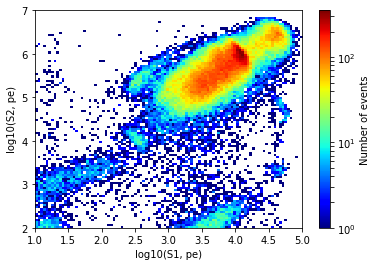

In [8]:
def twod_hist(d):
    # Remove events with no S1 or S2
    d = d[(d['s1'] > 0) & (d['s2'] > 0)]
    
    # Make an S1 vs S2 histogram
    plt.hist2d(np.log10(d['s1']), np.log10(d['s2']),
               bins=100, 
               range=((1, 5), (2, 7)),
               cmap=plt.cm.jet,
               norm=matplotlib.colors.LogNorm()   # Logarithmic color scale
    )
    plt.colorbar(label='Number of events')
    
    plt.xlabel('log10(S1, pe)')
    plt.ylabel('log10(S2, pe)')
    plt.show()
    
twod_hist(data)

Notice several photopeaks of gamma rays at high cS1 and high cS2. There is also a band of lower-energy signals, corresponding to elastic nuclear recoils (the reason we do the neutron generator calibration). There are many more features - some correspond to pathological events, since we have not applied any event selections.

## Event selections

Let's try to select some good events. If you've worked with pandas before, you're probably used to applying selections with boolean arrays/Series:

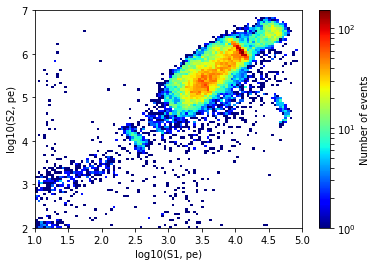

In [9]:
# Define a new variable to cut on
data['r'] = (data['x_pax']**2 + data['y_pax']**2)**0.5

# Load unit system
from pax import units

# Remove events just below the surface or without a valid S1-S2 combination
d = data
d = d[d['drift_time'] > 10 * units.us]

# Remove events at the very edge of the detector
d = d[d['r'] < 45 * units.cm]

# Remove double scatters (large secondary S2)
d = d[d['largest_other_s2'] < np.clip(0.1 * d['s2'], 70, None)]

twod_hist(d)

This style of selections is simple and totally fine. However, if you do many event selections, you might want to keep track of how many events are cut by what selection. Hax includes helpers for this:

drift_time above 10000.0 selection: 17491 rows removed (80.28% passed)
r below 45.0 selection: 15976 rows removed (77.56% passed)
Remove double scatters selection: 35361 rows removed (35.95% passed)


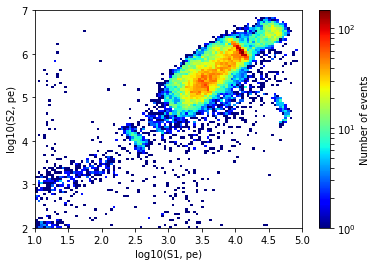

In [10]:
d = data
d = hax.cuts.above(d, 'drift_time', 10 * units.us)
d = hax.cuts.below(d, 'r', 45 * units.cm)
d = hax.cuts.selection(d, 
                       d['largest_other_s2'] < np.clip(0.1 * d['s2'], 70, None),
                       desc='Remove double scatters')
twod_hist(d)

Notice you got a print statement when you applied each cut. Moreover, hax.cuts.history can show you a list of all cuts that were applied, and what happened to the events:

In [11]:
df = hax.cuts.history(d)
df

,selection_desc,n_before,n_after,n_removed,fraction_passed,cumulative_fraction_left
0,drift_time above 10000.0,88675,71184,17491,0.802752,0.802752
1,r below 45.0,71184,55208,15976,0.775568,0.622588
2,Remove double scatters,55208,19847,35361,0.359495,0.223817


Incidentally, if you want to put these tables (or any other pandas dataframes) in your notes on the XENON wiki, there's a helper for that too:

In [12]:
print(hax.misc.dataframe_to_wiki(df, title="Table 1: cuts applied in my analysis"))

^ Table 1: cuts applied in my analysis ^^^^^^
^ selection_desc ^ n_before ^ n_after ^ n_removed ^ fraction_passed ^ cumulative_fraction_left ^
| drift_time above 10000.0 | 88675 | 71184 | 17491 | 0.80275 | 0.80275 |
| r below 45.0 | 71184 | 55208 | 15976 | 0.77557 | 0.62259 |
| Remove double scatters | 55208 | 19847 | 35361 | 0.3595 | 0.22382 |

